# Stationarity test

In [74]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd


INPUT_PATH = "hdfs://BigDataHA/user/s277309/recsys_data/"

features = [
    # Tweet features
    "text_tokens",      # List[long]    Ordered list of Bert ids corresponding to Bert tokenization of Tweet text
    "hashtags",         # List[string]  Tab separated list of hastags (identifiers) present in the tweet
    "tweet_id",         # String        Tweet identifier (unique)
    "present_media",    # List[String]  Tab separated list of media types. Media type can be in (Photo, Video, Gif)
    "present_links",    # List[string]  Tab separated list of links (identifiers) included in the Tweet
    "present_domains",  # List[string]  Tab separated list of domains included in the Tweet (twitter.com, dogs.com)
    "tweet_type",       # String        Tweet type, can be either Retweet, Quote, Reply, or Toplevel
    "language",         # String        Identifier corresponding to the inferred language of the Tweet
    "tweet_timestamp",  # Long          Unix timestamp, in sec of the creation time of the Tweet
    
    # Engaged-with User (i.e., Engagee) Features
    "engaged_with_user_id",                 # String    User identifier
    "engaged_with_user_follower_count",     # Long      Number of followers of the user
    "engaged_with_user_following_count",    # Long      Number of accounts the user is following
    "engaged_with_user_is_verified",        # Bool      Is the account verified?
    "engaged_with_user_account_creation",   # Long      Unix timestamp, in seconds, of the creation time of the account
    
    # Engaging User (i.e., Engager) Features
    "engaging_user_id",                     # String    User identifier   
    "engaging_user_follower_count",         # Long      Number of followers of the user
    "engaging_user_following_count",        # Long      Number of accounts the user is following
    "engaging_user_is_verified",            # Bool      Is the account verified?
    "engaging_user_account_creation",       # Long      Unix timestamp, in seconds, of the creation time of the account
    
    # Engagement features
    "engagee_follows_engager"   # Bool  Engagee follows engager?
]

features_idx = dict(zip(features, range(len(features))))

labels_idx = {
    # Engagement features (cont.)
    "reply_timestamp": 20,                  # Long      Unix timestamp (in seconds) of one of the replies, if there is at least one
    "retweet_timestamp": 21,                # Long      Unix timestamp (in seconds) of the retweet by the engaging user, if there is at least one
    "retweet_with_comment_timestamp": 22,   # Long      Unix timestamp (in seconds) of one of the retweet with comment by the engaging user, if there is at least one
    "like_timestamp": 23                    # Long      Unix timestamp (in seconds) of the like by the engaging user, if they liked the tweet
}

labels_short = ["reply", "rt", "rt_com", "like"]

## Approach 1: visual test

We plot the distribution of the four targets each week and each day.

In [53]:
# Read data
lines_rdd = sc.textFile(INPUT_PATH)

# Split each line
# Fields in each data entry are separated by the 1 character (0x31 in UTF-8).
# https://recsys-twitter.com/code/snippets
fields_rdd = lines_rdd.map(lambda line: line.strip().split("\x01"))

# Transform each element (row) -> (timestamp, interaction type)
def interaction_list(line):
    l = []
    
    for label, label_short in zip(labels_idx, labels_short):
        if len(line[labels_idx[label]]) > 0:
            l.append((line[labels_idx[label]], label_short))
    
    return l

interactions_rdd = fields_rdd.flatMap(interaction_list)

# Map timestamps to days&hours, 4-00 to 24-23 -> ("day_number-hour", interaction type)
day_hour_interaction_rdd = interactions_rdd.map(lambda pair: (datetime.utcfromtimestamp(int(pair[0])).strftime('%d-%H'), pair[1]))

In [54]:
%%time
day_hour_interaction_count = day_hour_interaction_rdd.countByValue()

CPU times: user 3.44 s, sys: 808 ms, total: 4.24 s
Wall time: 3min 45s


In [59]:
len(dict(day_hour_interaction_count)) == 21*24*4

True

In [66]:
list(day_hour_interaction_count.items())[:10]

[(('14-00', 'like'), 523100),
 (('17-22', 'rt'), 110660),
 (('09-21', 'like'), 621403),
 (('24-14', 'like'), 737860),
 (('22-23', 'rt'), 103062),
 (('22-23', 'like'), 562828),
 (('14-19', 'like'), 625188),
 (('16-13', 'like'), 756259),
 (('04-04', 'like'), 409840),
 (('06-00', 'like'), 534154)]

Visualize a time series for each type of interaction.

In [130]:
count_list = []
for k, v in dict(day_hour_interaction_count).items():
    if type(k) is not int:
        count_list.append([k[0], k[1], v])

count_df = pd.DataFrame(count_list, columns=["date", "type", "count"])
count_type_df_dict = {lab: count_df[count_df["type"] == lab].sort_values(by=["date"]) for lab in labels_short}

In [150]:
count_type_df_dict["like"]

,date,type,count
561,04-00,like,231556
325,04-01,like,337304
625,04-02,like,425184
175,04-03,like,478910
8,04-04,like,409840
...,...,...,...
450,24-19,like,588568
878,24-20,like,601696
153,24-21,like,618391
294,24-22,like,632425


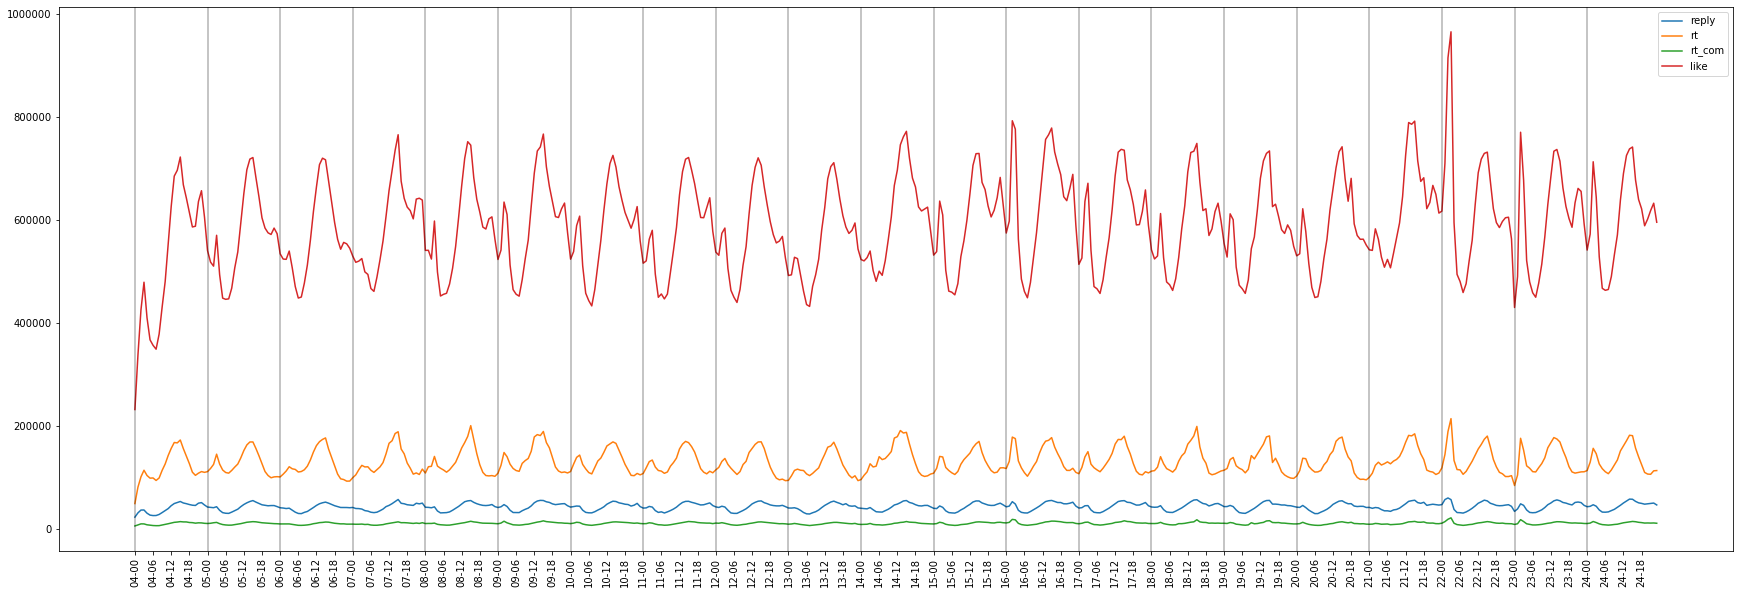

In [167]:
fig, ax = plt.subplots(figsize=(30, 10))

for lab in labels_short:
    ax.plot(count_type_df_dict[lab]["count"].to_numpy(),
            label=lab)
    
for d in range(0, 21*24, 24):
    ax.axvline(x=d, color="black", alpha=0.3)

ax.set_xticks(list(range(0, 504, 6)))
ax.set_xticklabels(count_type_df_dict["like"]["date"].to_list()[::6], rotation=90)
ax.legend()

plt.show()

- Strong within-day seasonality
- Not much difference over days
- Correlation between interaction types (e.g., see activity spike at Feb 22)
- First day has less interactions since past tweets are unavailable (how to we account for this?)